# Deploy

In [81]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt

In [55]:
test= pd.read_pickle("../data/processed/test_value.pkl")  
test.set_index(["spotName","TimeStamp"],inplace=True)
test

,,VoltageCurve,CurrentCurve
spotName,TimeStamp,,
60185_0_00,2020-02-26 15:35:27,"[146, 806, 1356, 1657, 1803, 1869, 1825, 1759,...","[322, 2184, 4046, 5407, 6374, 7054, 7340, 7519..."


# Statistical Detection

In [56]:
exploded_voltage=pd.DataFrame(test.VoltageCurve.tolist(), index= test.index)
exploded_current=pd.DataFrame(test.CurrentCurve.tolist(), index= test.index)
n=len(exploded_voltage.columns)
m=len(exploded_current.columns)

### Picchi o cali anomali

In [57]:
lag_reference= pd.read_pickle("../data/reference/reference_volt_lag_curves.pkl") 
upper_lag=lag_reference["upper_lag"]
lower_lag=lag_reference["lower_lag"]

In [59]:
voltage_lag5=exploded_voltage.iloc[:,:624].diff(periods=5,axis=1)
voltage_lag5=voltage_lag5.fillna(0)
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un calo di tensione
test["voltage_drop"]=voltage_lag5.apply(lambda x : any(x<lower_lag[:n]),axis=1)
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un picco di tensione
test["voltage_spike"]=voltage_lag5.apply(lambda x : any(x>lower_lag[:n]),axis=1)

In [60]:
test

,,VoltageCurve,CurrentCurve,voltage_drop,voltage_spike
spotName,TimeStamp,,,,
60185_0_00,2020-02-26 15:35:27,"[146, 806, 1356, 1657, 1803, 1869, 1825, 1759,...","[322, 2184, 4046, 5407, 6374, 7054, 7340, 7519...",True,True


### Anomalie puntuali

##### Voltaggio

In [90]:
curve_reference= pd.read_pickle("../data/reference/reference_volt_curves.pkl") 
upper_limit=curve_reference["upper_limit"]
lower_limit=curve_reference["lower_limit"]
media_volt=curve_reference["media"]

In [75]:
single_outliers=exploded_voltage.apply(lambda x : x.between(lower_limit[:n],upper_limit[:n]) ,axis=1)
test["n_voltage_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)
test["%volt_anomalies"]=test.apply(lambda x: round(x.n_voltage_outliers/n*100),axis=1)
test

##### Corrente

In [91]:
curve_reference= pd.read_pickle("../data/reference/reference_current_curves.pkl") 
upper_limit=curve_reference["upper_limit"]
lower_limit=curve_reference["lower_limit"]
media_curr=curve_reference["media"]

In [80]:
single_outliers=exploded_current.apply(lambda x : x.between(lower_limit[:m],upper_limit[:m]) ,axis=1)
test["n_current_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)
test["%curr_anomalies"]=test.apply(lambda x: round(x.n_voltage_outliers/m*100),axis=1)
test

,,VoltageCurve,CurrentCurve,voltage_drop,voltage_spike,n_voltage_outliers,%volt_anomalies,n_current_outliers,%curr_anomalies
spotName,TimeStamp,,,,,,,,
60185_0_00,2020-02-26 15:35:27,"[146, 806, 1356, 1657, 1803, 1869, 1825, 1759,...","[322, 2184, 4046, 5407, 6374, 7054, 7340, 7519...",True,True,289,56,225,56


# ML Detection

In [ ]:
with open(r'..\Models\knn.pkl','rb') as file:
    model=pickle.load(file)
model

# Plot curva di test

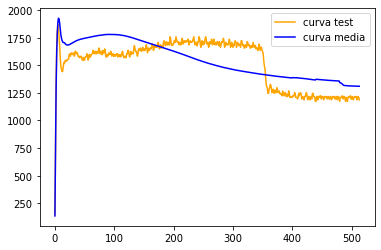

In [100]:
plt.plot(test.VoltageCurve[0],label="curva test",c="orange")
plt.plot(media_volt[:n],label="curva media",c="blue")
plt.legend();